In [1]:
import os
import numpy as np
import pandas as pd

**path指定**

In [2]:
base_dir = '/content/drive/MyDrive/kaggle/signLanguage/csv'
train_dir = base_dir + '/train'
test_dir = base_dir + '/test'

**trainのデータ読み込み**

In [3]:
# dir内のフォルダ数を数える
folder_count = 0
dir = train_dir
for path in os.listdir(dir):
    if os.path.isdir(os.path.join(dir, path)):
        folder_count += 1
print(folder_count)

20


In [4]:
for i in range(1,folder_count+1):
    exec_command = 'train_sign' + str(i) + "_path = train_dir + '/sign_" + str(i) + "/'"
    exec(exec_command)
    #print(exec_command)

In [5]:
train_sign1_path  # パス確認

'/content/drive/MyDrive/kaggle/signLanguage/csv/train/sign_1/'

In [6]:
frame = 60
train_y=[]
for i in range(1,folder_count+1):
    # sign1-sign20のpathを指定
    path_exec_command = 'path = train_sign' + str(i) + '_path'
    exec(path_exec_command)
    #print(path_exec_command)

    files=os.listdir(path)
    #print(files)
    lists=[]  # 同じsignのデータを3次元listに格納する
    for file in files:
        #print(file)
        df = pd.read_csv(path+file, index_col=0)

        df = df.iloc[:,1404:]  # 顔の情報を削除468x3
        df = df.iloc[:,63:]  # 左手の情報を削除21x3

        df = df.fillna(0.1)  # 欠損データ

        # フレームの補完．60フレームに足りない場合は最後のフレームで補完     
        if len(df) < frame:
            for f in range(len(df), frame):
                df=df.append(df.tail(1))
        #print(df)

        lists.append(df.values[:frame, :].tolist())  # signごとに結合
        train_y.append(i - 1)# ラベル
    csv_exec_command = 'train_sign' + str(i) + '= np.array(lists)'
    exec(csv_exec_command)
    #print(csv_exec_command)

In [7]:
print(train_sign1.shape) # 動画数,フレーム数,特徴量

(40, 60, 162)


In [8]:
train_y=np.array(train_y)
#train_y
train_y.shape

(800,)

**trainデータの結合**

In [9]:
train_x=train_sign1
for i in range(2,folder_count+1):
    exec_command = 'train_x = np.concatenate([train_x, train_sign'+ str(i) +'], 0)'
    #print(exec_command)
    exec(exec_command)

print(train_x.shape)

(800, 60, 162)


**trainとvalidを分割する**

In [10]:
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(train_x, np_utils.to_categorical(train_y), test_size=0.1)

In [11]:
train_x.shape[1:]

(60, 162)

**モデルの構成**

In [12]:
from keras.layers.advanced_activations import LeakyReLU
from keras import layers
from keras import models
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.models import Sequential
from keras.layers import Dense, Dropout,LeakyReLU
from keras import optimizers

model = Sequential()
model.add(LSTM(64, return_sequences=False, activation='tanh', input_shape=train_x.shape[1:]))
model.add(Dense(train_y.shape[1], activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                58112     
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
Total params: 59,412
Trainable params: 59,412
Non-trainable params: 0
_________________________________________________________________


In [13]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=0.01, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
h=model.fit(train_x, 
            train_y, 
            epochs= 10000, 
            verbose=1, 
            validation_data=(val_x, val_y))

ストリーミング出力は最後の 5000 行に切り捨てられました。
23/23 [==============================] - 3s 127ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4264 - val_accuracy: 0.9000
Epoch 7502/10000
23/23 [==============================] - 3s 125ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4232 - val_accuracy: 0.9000
Epoch 7503/10000
23/23 [==============================] - 3s 125ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.4301 - val_accuracy: 0.9000
Epoch 7504/10000
23/23 [==============================] - 3s 125ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.4209 - val_accuracy: 0.9000
Epoch 7505/10000
23/23 [==============================] - 3s 127ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.4310 - val_accuracy: 0.9000
Epoch 7506/10000
23/23 [==============================] - 3s 126ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.4117 - val_accuracy: 0.9000
Epoch 7507/10000
23/23 [==============================] - 3s 125ms/step - loss: 0.0011 - accuracy

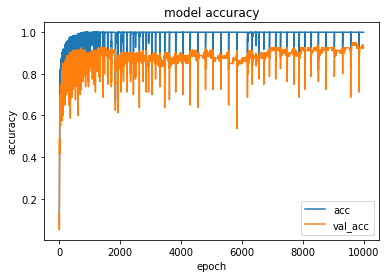

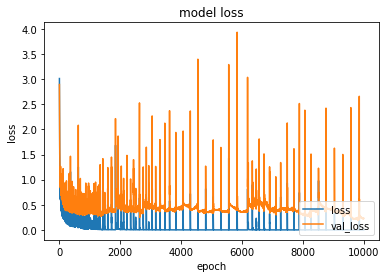

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    # print(history.history.keys())

    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

plot_history(h)

In [16]:
# 学習結果を保存する
hdf5_file = os.path.join(base_dir, '../LSTM.hdf5')
model.save(hdf5_file)